# Classification of Handwritten Digits from the MNIST Database

We will illustrate multiple Machine Learning algorithms by using them for classifying handwritten digits.

# Using Classwise Logistic Regression

Here we perform [logistic regression](http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/) on each class of digit. For a given digit, then we choose the class with maximum (log) likelihood that the digit belongs to that class. We use stochastic gradient descent to get the values of the regression parameters. 

Note here that these likelihoods are not probabilities that the digit belongs to a particular class (they need not even sum to 1). This is a discriminative algorithm.

The naive implementation of this algorithm is unlikely to give a very good result, as for each class the ratio of members of the class to non-members of the class is 1 : 9 (ie, the data is biased). Therefore, we correct for the bias in the data by taking a 1 : 1 ratio of class members and non-class members during gradient descent. 

In [12]:
# Import Statements

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [27]:
class MNIST_classifier : 

    def __init__(self, NUM_ITER = 6000, LEARN_RATE = 1e-2, BATCH_SIZE = 360, type_input = "logistic", Linear = True) : 

        # Our hyperparameters
        self.NUM_ITER = NUM_ITER
        self.LEARN_RATE = LEARN_RATE
        self.BATCH_SIZE = BATCH_SIZE
        self.Linear = Linear
        self.rbf_feature = RBFSampler(gamma=1, random_state=1)

        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train_r = np.zeros((x_train.shape[0], 1 + x_train.shape[1]*x_train.shape[2]))
        
        mean = np.mean(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)
        std_dev = np.std(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)

        for i in range(std_dev.shape[0]):
            if np.isclose(std_dev[i], 0):
                std_dev[i] = 1 # if STD DEV is close to 0, x - mean will already be close to 0, so we don't normalize

        for i in range(x_train_r.shape[0]):
            x_train_r[i] = np.insert((np.reshape(x_train[i], (x_train.shape[1]*x_train.shape[2], )) - mean)/std_dev, 0, 1)
        
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_train_r = x_train_r

        self.x_test = x_test
        self.y_test = y_test

        self.mean = mean
        self.std_dev = std_dev

        # Correct for bias in data
        num_to_list = {}
        for i in range(10):
            num_to_list[i] = []

        for i in range(x_train_r.shape[0]):
            num_to_list[y_train[i]].append(i)

        for i in range(10):
            num_to_list[i] = np.array(num_to_list[i])

        self.num_to_list = num_to_list
        self.type_input = type_input
        if type_input == "logistic" :
          self.lr = LogisticRegression(multi_class='multinomial', warm_start=True, max_iter=self.BATCH_SIZE)
  
        elif type_input == "softmax" :
          self.lr = SGDClassifier(loss="log")
          
        elif type_input == "GDA" :
          self.lr = GaussianNB()

        
        elif type_input == "SVM" : 
          self.lr = [SGDClassifier(max_iter = self.BATCH_SIZE, loss="hinge", penalty="l2") for i in range(45)]

    def grad_descent(self, digit, iterations, learning_rate):
        if self.type_input == "softmax" or self.type_input == "GDA": 
            for _ in range(iterations) :
                batch = np.concatenate(tuple([np.random.choice(self.num_to_list[p], int(self.BATCH_SIZE/9)) for p in range(10)]))
                batch_x = [self.x_train_r[i] for i in batch]
                batch_y = [self.y_train[i] for i in batch]
                self.lr.partial_fit(batch_x, batch_y, classes = tuple(range(10)))

        elif self.type_input == "SVM" :
            for i in range(10) : 
                for j in range(i+1, 10) : 
                    for _ in range(iterations) :
                        batch = np.concatenate(tuple([np.random.choice(self.num_to_list[p], int(self.BATCH_SIZE/2)) if p == i else np.random.choice(self.num_to_list[p], int(self.BATCH_SIZE/2)) for p in [i, j]]))
                        batch_x = [self.x_train_r[i] for i in batch]
                        batch_y = [self.y_train[i] for i in batch]
                        if not self.Linear :
                          
                          batch_x = self.rbf_feature.fit_transform(batch_x)
                        self.lr[int(45-(10-i)*(9-i)/2+j-i-1)].partial_fit(batch_x, batch_y, classes = (i, j))
            
        elif self.type_input == "logistic" :
            for _ in range(iterations) :
                batch = np.concatenate(tuple([np.random.choice(self.num_to_list[p], int(self.BATCH_SIZE/2)) if p == digit else np.random.choice(self.num_to_list[p], int(self.BATCH_SIZE/18)) for p in range(10)]))
                batch_x = [self.x_train_r[i] for i in batch]
                batch_y = [self.y_train[i] for i in batch]
                self.lr.fit(batch_x, batch_y)

    def train_model(self) :
        if self.type_input == "softmax" or self.type_input == "GDA" or self.type_input == "SVM":
            self.grad_descent(0, self.NUM_ITER, self.LEARN_RATE)

        if self.type_input == "logistic":
            for i in range(10) : 
              self.grad_descent(i, self.NUM_ITER//10, self.LEARN_RATE)

    def prediction(self, digit) :
        if self.type_input == "SVM" and self.Linear == True: 
          r_dig = np.insert((np.reshape(digit, (self.x_train.shape[1]*self.x_train.shape[2], )) - self.mean)/self.std_dev, 0, 1)
          freq = [i.predict(np.reshape(r_dig, (1, 785)))[0] for i in self.lr]
          return statistics.mode(freq)

        elif self.type_input == "SVM" : 
          r_dig = np.insert((np.reshape(digit, (self.x_train.shape[1]*self.x_train.shape[2], )) - self.mean)/self.std_dev, 0, 1)
          freq = [i.predict(self.rbf_feature.fit_transform(np.reshape(r_dig, (1, 785))))[0] for i in self.lr]
          return statistics.mode(freq)

        else : 
          r_dig = np.insert((np.reshape(digit, (self.x_train.shape[1]*self.x_train.shape[2], )) - self.mean)/self.std_dev, 0, 1)
          return self.lr.predict(np.reshape(r_dig, (1, 785)))[0]
    
    def tester(self) : 
        i = np.random.randint(0, self.x_test.shape[0])
        plt.imshow(self.x_test[i])
        print(f'Predicted: {self.prediction(self.x_test[i])}')
        print(f'Actual: {self.y_test[i]}')

    def accuracy(self) : 

        num_occ = 0
        for i in range(self.x_test.shape[0]):
            if self.prediction(self.x_test[i]) == self.y_test[i]:
                num_occ += 1

        print(f'Accuracy: {num_occ*100/self.x_test.shape[0]}%')

In [4]:
# Execution time ~ 2 minutes

model = MNIST_classifier(100, 1e-2, 180, "logistic")
model.train_model()
model.accuracy()

Accuracy: 69.37%


Predicted: 9
Actual: 5


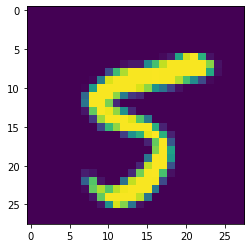

In [6]:
model.tester()

With ```6000``` iterations of gradient descent, a learning rate of ```0.01``` and a minibatch size of ```180```, we get an accuracy of ```88.54%```.

## Using Softmax Regression

[This](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/) is more appropriate for multiclass classification than plain logistic regression. Here the probabilities of a digit belonging to a class are drawn from a multivariate Bernoulli distribution, on which we perform maximum likelihood estimation via stochastic gradient descent. 

This is also a discriminative model.

In [ ]:
model = MNIST_classifier(600, 1e-2, 180, "softmax")
model.train_model()
model.accuracy()

Accuracy: 91.17%


Predicted: 5
Actual: 5


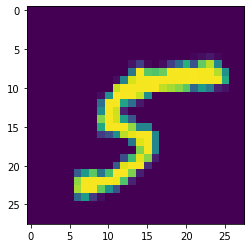

In [ ]:
model.tester()

With ```8000``` iterations of gradient descent, a learning rate of ```0.01``` and a minibatch size of ```500```, we get an accuracy of ```90.13%```.

## Gaussian Discriminant Analysis

We assume each class of digit is distributed according to some Multivariate Gaussian whose mean and covariance we calculate (using the sample mean and sample covariance of each digit). Have a look at the slides on Multivariate Gaussian for an overview.

To classify a digit then, we choose the class such that the probability that the digit belongs to the class is maximum. We calculate this probability using Baye's Theorem ( $P(y | x) = \frac{P(x | y)P(y)}{P(x)}$ ). This is an example of a generative learning model.

However, while calculating the sample covariance, it will come out to be singular or almost singular, as there are a large number of principal components with eigenvalues close to 0 (or 0). Therefore, we must reduce the dimensionality of the data by projecting it onto the space spanned by the first few principal components. Note that since we're already calculating the principal components here, there is no need to normalize the data.

In [ ]:
model = MNIST_classifier(600, 1e-2, 180, "GDA")
model.train_model()
model.accuracy()

Accuracy: 54.99%


Predicted: 6
Actual: 6


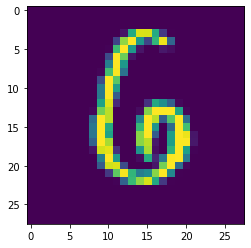

In [ ]:
model.tester()

### Hyperparameter Tuning
The hyperparameter here is the number of principal components considered. We choose the number that maximizes the accuracy on testing.

| Number of Principal Components           | Accuracy               |
| ---------------------------------------- | -----------------------|
| ```1```                                  | ```4.55%```            |
| ```80```                                 | ```94.24%```           |
| ```150```                                | ```95.59%```           |
| ```240```                                | ```94.78%```           |
| ```320```                                | ```93.72%```           |
| ```400```                                | ```91.45%```           |
| ```480```                                | ```87.61%```           |
| ```560```                                | ```65.83%```           |
| ```640```                                | ```9.8%```             |
| ```720```                                | ```9.8%```             |
| ```784```                                | ```9.8%```             |


# Using Support Vector Machines

Here we make ${10\choose 2} = 45$ support vector machines that can distinguish every pair of classes. We will use Linear and RBF/Gaussian Kernels for the support vector machines and use Constrained Stochastic Gradient Descent for optimization.

The support vector machine is another discriminative algorithm, but this one can identify non-linear decision boundaries as well.

For a given image, we will map it to the digit to which it is classified the most (on average, the image will be mapped to the correct digit $\frac{9}{4}$ times more than the other digits).

In [32]:
# Running time ~ 1 min

model = MNIST_classifier(200, 1e-2, 180, "SVM", True)
model.train_model()
model.accuracy()

Accuracy: 91.69%


Predicted: 4
Actual: 4


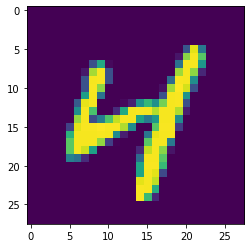

In [34]:
model.tester()